In [46]:
#Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [47]:
# Cargar datos
csv_path = "../../data/raw/JNJ.csv"
df = pd.read_csv(csv_path, parse_dates=["Date"])

#Estilo
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)

In [48]:
# Información general del DataFrame
print("\nInformación del DataFrame:")
print(df.info())


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1075 non-null   datetime64[ns]
 1   Close   1075 non-null   float64       
 2   High    1075 non-null   float64       
 3   Low     1075 non-null   float64       
 4   Open    1075 non-null   float64       
 5   Volume  1075 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 50.5 KB
None


In [49]:
# Verificar valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())


Valores faltantes por columna:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


Se evidencia que el dataset no presenta valores ausentes, por lo que no es necesario tratarlos. 

In [50]:
# Estadísticas descriptivas sin la columna "Date"
print("\nEstadísticas descriptivas:")
print(df.drop(columns=["Date"]).describe())


Estadísticas descriptivas:
             Close         High          Low         Open        Volume
count  1075.000000  1075.000000  1075.000000  1075.000000  1.075000e+03
mean    152.863016   153.926487   151.722574   152.829771  8.261321e+06
std       7.095441     7.146102     7.020541     7.078626  8.326624e+06
min     135.247879   135.753488   134.671305   134.697915  2.114900e+06
25%     147.404037   148.239658   146.171480   147.279059  5.704300e+06
50%     152.584488   153.582916   151.461431   152.495945  6.868500e+06
75%     157.613037   158.639866   156.480829   157.517742  8.500950e+06
max     170.243530   170.865900   168.568611   169.410642  1.513195e+08


In [51]:
# Returns diarios
df["Return"] = df["Close"].pct_change()


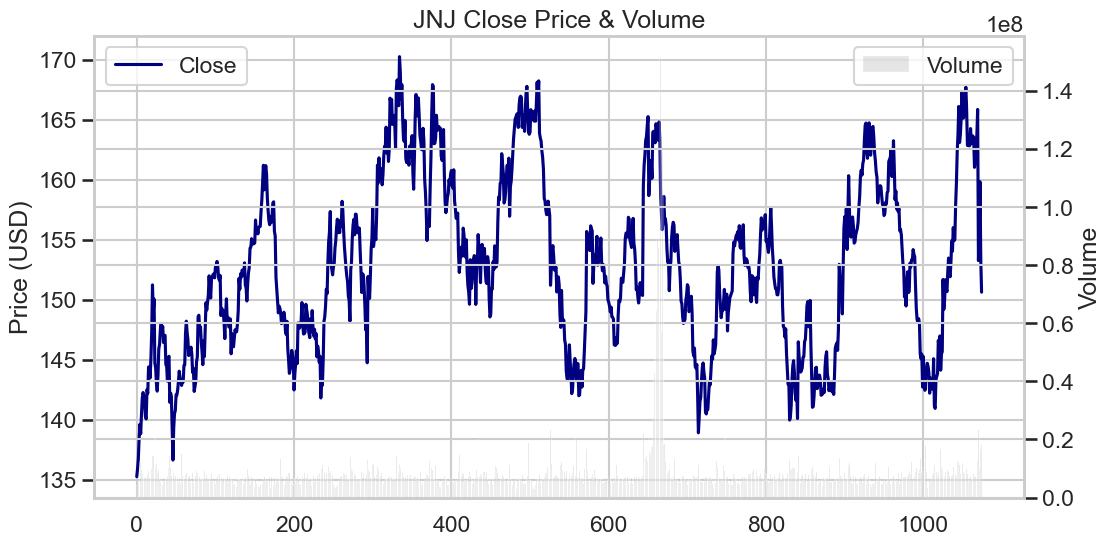

In [52]:
# Closing Price & Volume
fig, ax1 = plt.subplots()
ax1.plot(df["Close"], color="navy", label="Close")
ax1.set_ylabel("Price (USD)")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.bar(df.index, df["Volume"], alpha=0.2, color="gray", label="Volume")
ax2.set_ylabel("Volume")
ax2.legend(loc="upper right")
plt.title("JNJ Close Price & Volume")
plt.show()

En este gráfico de precio de cierre y volumen de JNJ se aprecia que, a lo largo del período analizado, el precio oscila dentro de un canal aproximado de 135 – 170 USD, con varios ciclos de alzas sostenidas seguidas de correcciones pronunciadas. Los picos de volumen (barras más altas) tienden a coincidir con los puntos de inflexión del precio, indicando que los días de mayor negociación suelen marcar inicios o cierres de tendencias. En contraste, durante los tramos laterales o de consolidación el volumen se mantiene relativamente bajo, lo que sugiere menor interés de mercado y menor volatilidad en el precio. Este comportamiento es típico en acciones de gran capitalización: movimientos impulsados por noticias o resultados trimestrales generan volumen elevado y cambios bruscos de precio, mientras que en períodos neutrales el mercado se estabiliza.

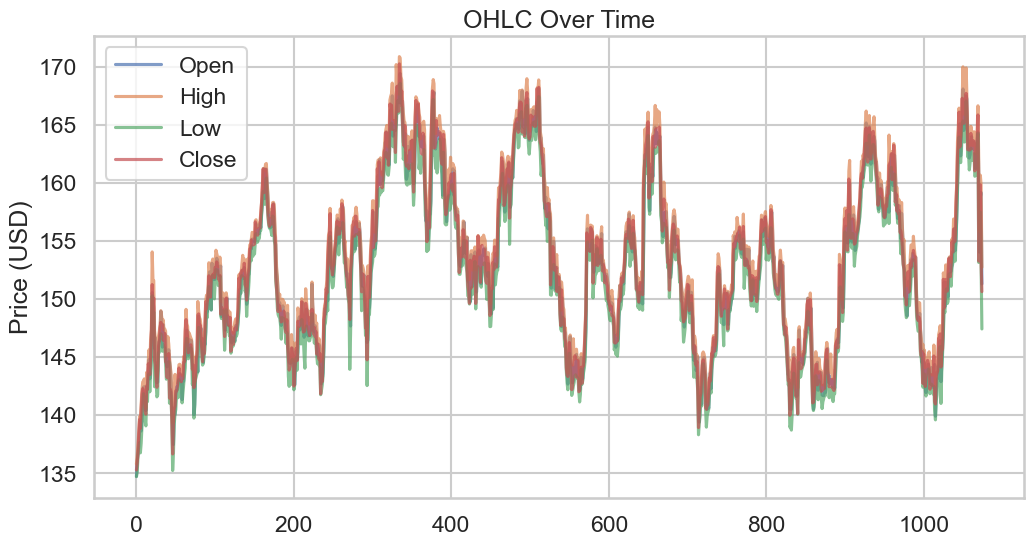

In [53]:
#Open/High/Low/Close Overlay
df[["Open","High","Low","Close"]].plot(alpha=0.7)
plt.title("OHLC Over Time")
plt.ylabel("Price (USD)")
plt.show()


En la superposición de las series Open, High, Low y Close se aprecia que los cuatro precios se mueven casi solapados, lo que indica que los “gaps” intradía (diferencias entre cierre y apertura siguiente) son poco frecuentes y de tamaño reducido. El rango diario (High–Low) también es relativamente estrecho, señal de baja volatilidad intradía en la mayoría de las sesiones. Sin embargo, a lo largo del período se distinguen claros ciclos de tendencia alcista y bajista: cuando el precio sube o baja con fuerza, las cuatro líneas se separan un poco más, mostrando velas con cuerpos y mechas más largos. En los tramos laterales, en cambio, todas convergen y el mercado entra en consolidación.

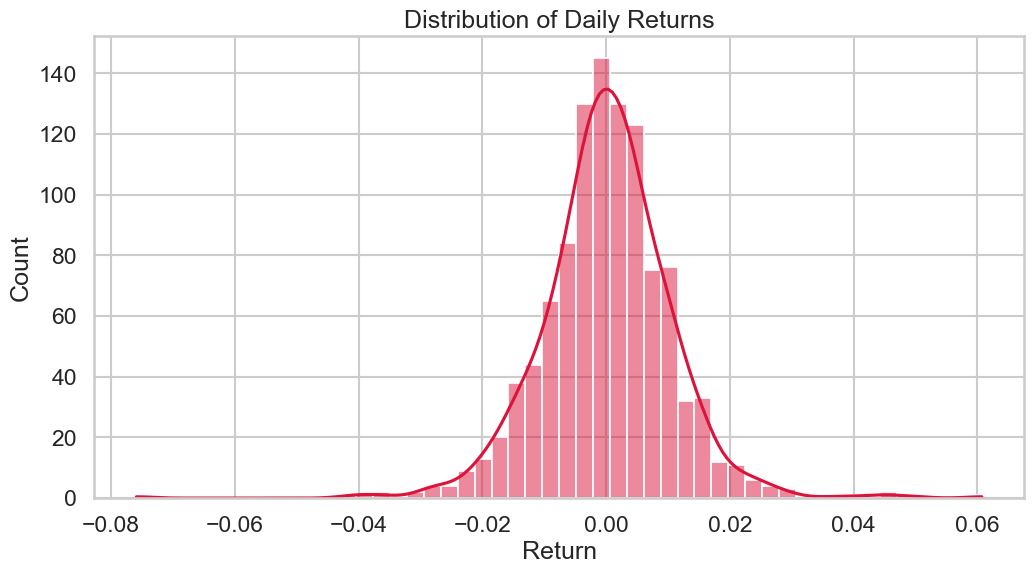

In [54]:
#Histograma del Returno Diario
sns.histplot(df["Return"].dropna(), bins=50, kde=True, color="crimson")
plt.title("Distribution of Daily Returns")
plt.xlabel("Return")
plt.show()

La distribución de retornos diarios de JNJ está muy concentrada alrededor de cero, con la mayoría de los días mostrando variaciones pequeñas (±1 %). Sin embargo, se aprecian colas relativamente gruesas: hay más ocurrencias de movimientos extremos (tanto alcistas como bajistas) de las que cabría esperar en una distribución normal. Además, la leve asimetría hacia la izquierda (cola negativa algo más pronunciada) sugiere que las caídas fuertes son un poco más frecuentes o bruscas que las subidas equivalentes. En conjunto, esto indica un comportamiento leptocúrtico y un ligero sesgo negativo, factores importantes a considerar al modelar riesgos y diseñar estrategias de trading.

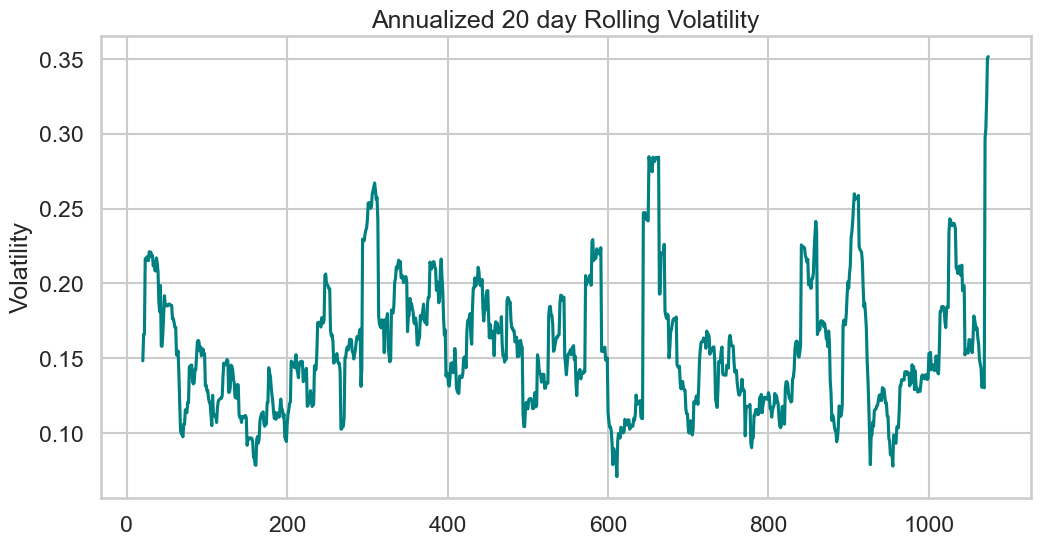

In [55]:
#Rolling Volatility (20‑dias)
df["Volatility20"] = df["Return"].rolling(20).std() * np.sqrt(252)
df["Volatility20"].plot(color="teal")
plt.title("Annualized 20 day Rolling Volatility")
plt.ylabel("Volatility")
plt.show()

En la serie de volatilidad anualizada a 20 días se observan claros ciclos de riesgo: períodos de baja volatilidad (por debajo de 0.12–0.15) alternan con picos pronunciados que superan 0.20 e incluso 0.30, reflejando momentos de alta incertidumbre o noticias relevantes para JNJ. Los valles prolongados sugieren fases de mercado tranquilo y consolidación, donde los retornos diarios son más predecibles, mientras que los máximos abruptos marcan episodios de tensión —quizá en torno a resultados trimestrales o eventos macro— que podrían desencadenar estrategias de protección o rotación de posiciones. Este comportamiento no estacionario indica que cualquier modelo predictivo debe adaptarse dinámicamente a cambios en la volatilidad para no subestimar el riesgo en los picos.

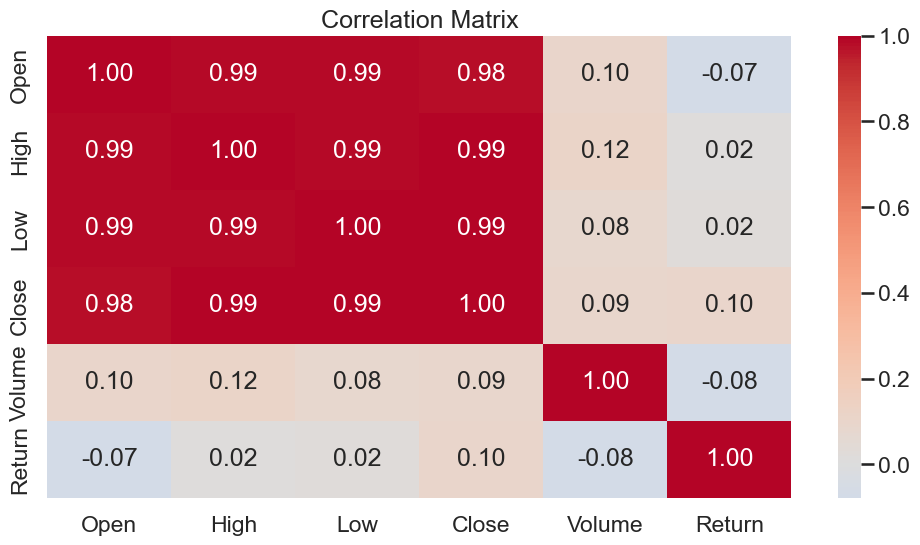

In [56]:
#Analisis de Correlacion
corr = df[["Open","High","Low","Close","Volume","Return"]].dropna().corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

En la matriz de correlación se ve que las cuatro cotizaciones diarias (Open, High, Low y Close) están casi perfectamente alineadas (correlaciones entre 0.98 y 0.99), lo cual refleja que cualquier cambio en el precio afecta de modo muy parecido a todos esos valores. El volumen muestra una correlación débilmente positiva (0.10) con los precios, indicando que los días de mayor negociación suelen coincidir con ligeros movimientos de precio, pero no de forma determinante. Por su parte, los retornos diarios están prácticamente no correlacionados con los niveles de precio (cerca de 0.00) y tienen una correlación levemente negativa con el volumen (–0.08), sugiriendo que las jornadas de alta actividad tienden a asociarse con caídas algo más frecuentes que con subidas.

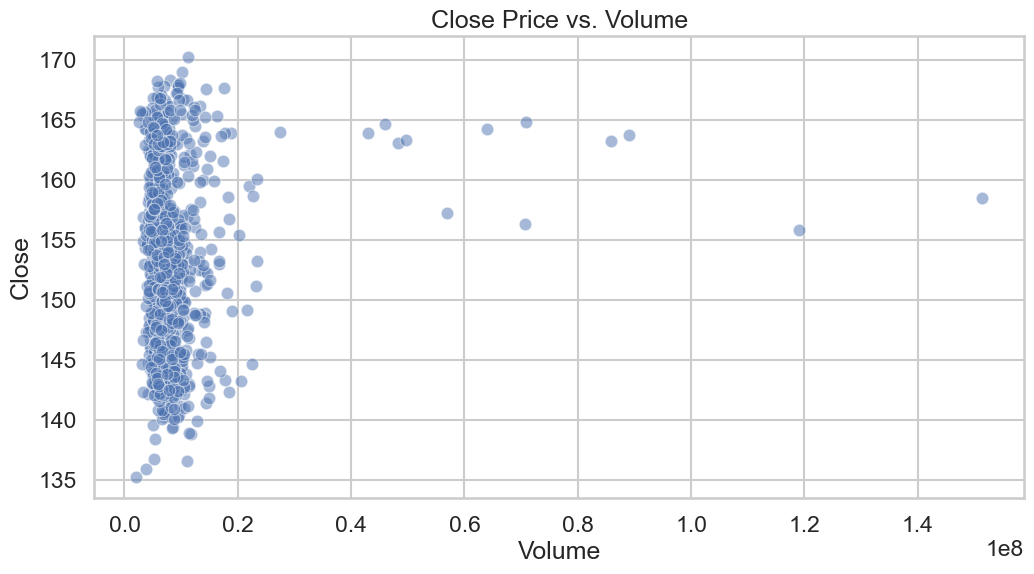

In [57]:
#Close vs. Volume
sns.scatterplot(x="Volume", y="Close", data=df, alpha=0.5)
plt.title("Close Price vs. Volume")
plt.show()

En el diagrama de dispersión “Close Price vs. Volume” se observa que la gran mayoría de los días operativos tienen volúmenes moderados (entre 20 y 60 millones de acciones) sin un patrón claro de precios: los cierres se concentran en el rango 140–165 USD independientemente del volumen. Los pocos puntos de volumen extraordinariamente alto (por encima de 80 millones) aparecen tanto en picos de precio como en mínimos relativos, lo que confirma que un aumento brusco en la negociación no garantiza ni subidas ni bajadas consistentes. En conjunto, esto refuerza la idea de que el nivel de volumen por sí solo no explica la dirección del precio de cierre y debe combinarse con otras variables para mejorar la predictibilidad.

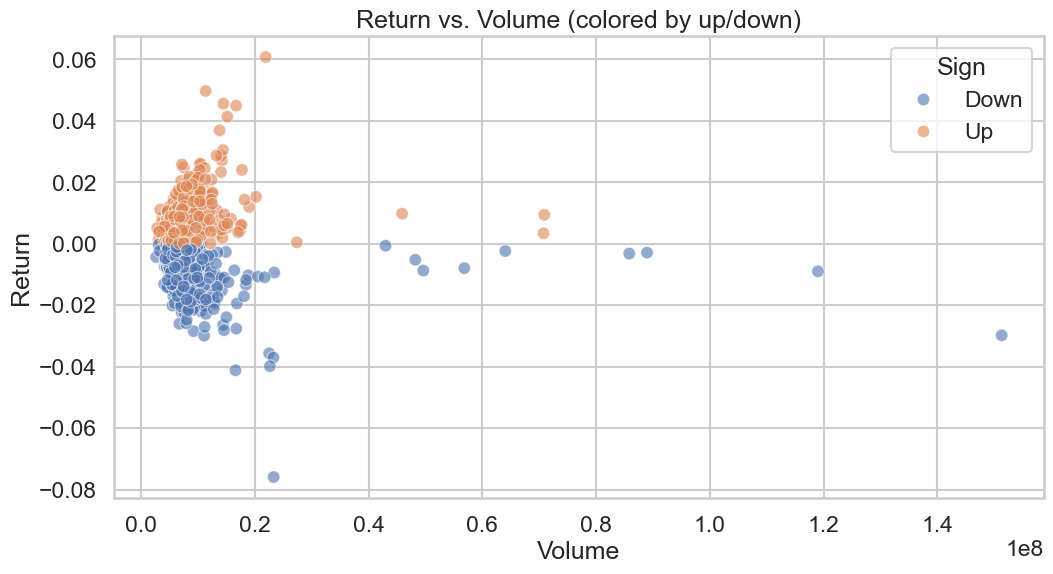

In [58]:
#Return vs. Volume (up vs down days)
df["Sign"] = np.where(df["Return"]>0, "Up", "Down")
sns.scatterplot(x="Volume", y="Return", hue="Sign", data=df, alpha=0.6)
plt.title("Return vs. Volume (colored by up/down)")
plt.show()

En este diagrama de “Return vs. Volume” coloreado por subidas (naranja) y bajadas (azul) se confirma que los picos de volumen extremo —aquellos puntos a la derecha— no garantizan la dirección del mercado: tanto las mayores ganancias diarias como las caídas más bruscas aparecen en jornadas de alta negociación. Sin embargo, se aprecia una ligera concentración de puntos azules en los volúmenes más altos, lo que sugiere que los movimientos bajistas tienden a asociarse con incrementos de actividad algo más pronunciados que las subidas. En el rango de volúmenes moderados (20–60 millones), los retornos se distribuyen de forma más simétrica, indicando que el volumen por sí solo no es un predictor fiable de la magnitud o signo del retorno diario.

In [59]:
#Busqueda de outliers
# Seleccionar únicamente columnas numéricas (excluyendo "Date")
numeric_cols = df.select_dtypes(include=["number"]).columns

# Diccionario para almacenar los outliers por columna
outliers_dict = {}

for col in numeric_cols:
    # Calcular los cuartiles e IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites inferior y superior
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar los outliers para la columna
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_dict[col] = outliers

    # Mostrar resultados (incluye la fecha para identificar en qué fila se encuentran)
    print(f"Outliers en la columna '{col}':")
    if not outliers.empty:
        print(outliers[["Date", col]])
    else:
        print("No se encontraron outliers.")
    print("\n")


Outliers en la columna 'Close':
No se encontraron outliers.


Outliers en la columna 'High':
No se encontraron outliers.


Outliers en la columna 'Low':
No se encontraron outliers.


Outliers en la columna 'Open':
No se encontraron outliers.


Outliers en la columna 'Volume':
           Date    Volume
20   2021-01-26  14205700
21   2021-01-27  14207300
23   2021-01-29  22505900
42   2021-02-26  14417500
57   2021-03-19  14891500
...         ...       ...
1063 2025-03-21  17047100
1070 2025-04-01  23303100
1072 2025-04-03  13249300
1073 2025-04-04  16601700
1074 2025-04-07  18083000

[74 rows x 2 columns]


Outliers en la columna 'Return':
           Date    Return
20   2021-01-26  0.027112
23   2021-01-29 -0.035647
42   2021-02-26 -0.026419
78   2021-04-20  0.023296
177  2021-09-09 -0.022280
205  2021-10-19  0.023420
234  2021-11-30 -0.023913
247  2021-12-17 -0.027628
272  2022-01-25  0.028594
294  2022-02-25  0.049703
306  2022-03-15  0.025919
322  2022-04-06  0.026012
330  2022-04-19

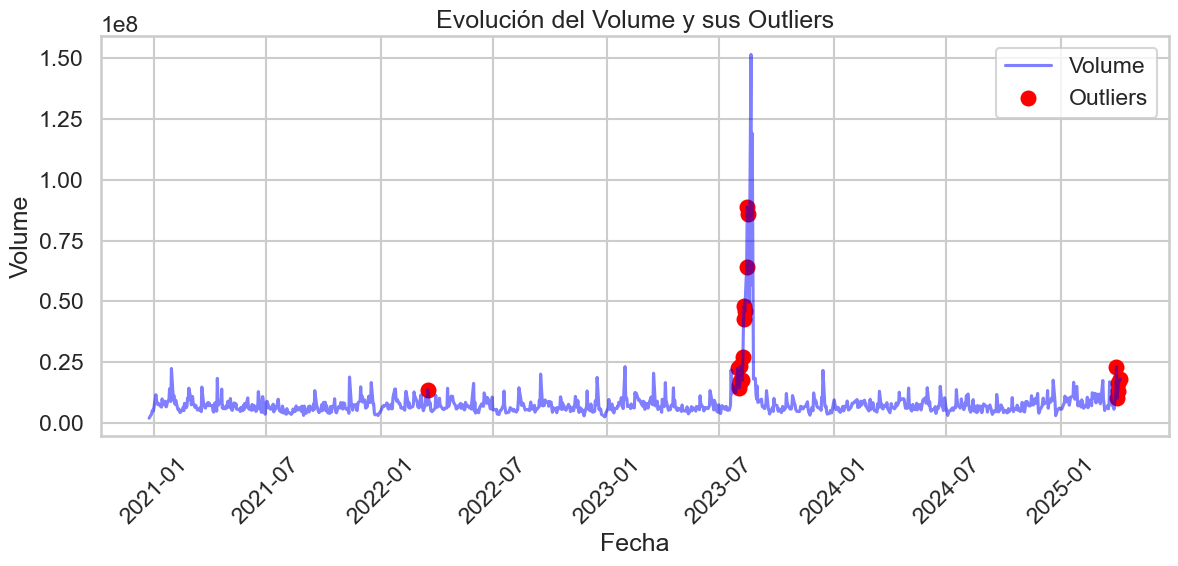

In [60]:
# Dibujar el gráfico
plt.figure(figsize=(12, 6))
# Graficamos la serie completa de Volume a lo largo del tiempo
plt.plot(df["Date"], df["Volume"], label="Volume", color="blue", alpha=0.5)
# Superponemos los outliers en rojo
plt.scatter(outliers["Date"], outliers["Volume"], color="red", label="Outliers", marker="o", s=100)
plt.xlabel("Fecha")
plt.ylabel("Volume")
plt.title("Evolución del Volume y sus Outliers")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Los valores atípicos no se van a eliminar, pues son precisamente los movimientos del mercado que el modelo debe detectar. En su lugar, se va a controlar su magnitud (logaritmo o winsorización). Además, se van a marcar explícitamente, y se van a ampliar con características de eventos para que el modelo pueda interpretarlos correctamente.